In [1]:
# Global imports
import biosteam as bst, thermosteam as tmo, biorefineries as bf, numpy as np, pandas as pd
from biorefineries import cellulosic
from biosteam import main_flowsheet as F, units

In [2]:
# Local imports
from atj_saf.atj_bst.etj_chemicals import *
from atj_saf.atj_bst.etj_settings import feed_parameters, dehyd_data, olig_data, prod_selectivity, hydgn_data, price_data, h2_recovery, gal_to_m3
from atj_saf.atj_bst.etj_utils import calculate_ethanol_flow, ethanol_price_converter
from atj_saf.atj_bst.atj_bst_units import AdiabaticReactor, IsothermalReactor, EthanolStorageTank, HydrocarbonProductTank, HydrogenStorageTank, CatalystMixer
from atj_saf.atj_bst.atj_bst_tea_saf import ConventionalEthanolTEA
from cellulosic_tea_etj import create_cellulosic_ethanol_tea

In [3]:
bst.F.set_flowsheet('etj') # F is the main flowsheet


In [4]:
atj_chems = create_chemicals()
bst.settings.set_thermo(atj_chems) # Setting thermodynamic property pacakge for the chemicals


In [5]:
bst.settings.CEPCI = 800.8 # For the year 2023 from https://personalpages.manchester.ac.uk/staff/tom.rodgers/Interactive_graphs/CEPCI.html?reactors/CEPCI/index.html
bst.settings.electricity_price = price_data['electricity']

In [6]:
etoh_flow = calculate_ethanol_flow(9) 

In [7]:
# Bioethanol feed
etoh_in = bst.Stream(
    'Ethanol_In',
    Ethanol = etoh_flow,
    Water =  etoh_flow*((1-feed_parameters['purity'])/(feed_parameters['purity'])),
    units = 'kg/hr',
    T = feed_parameters['temperature'],
    P = feed_parameters['pressure'],
    phase = feed_parameters['phase'])




In [8]:
 # Reactions

#1) Gas phase dehydration of ethanol to ethylene 
dehydration_rxn = bst.Reaction('Ethanol,g -> Water,g + Ethylene,g', reactant = 'Ethanol', 
                            X = dehyd_data['conv'], phases = 'lg',  basis = 'mol')


#2) Ethylene oligomerization to olefins in gas and liquid phase
oligomerization_rxn = bst.ParallelReaction([
# Reaction definition                                     # Reactant                    # Conversion
bst.Reaction('2Ethylene,g -> Butene,g',            reactant = 'Ethylene',     X = olig_data['conv']*prod_selectivity['C4H8'],    basis = 'wt',  phases = 'lg',  correct_atomic_balance = True),
bst.Reaction('1.5Ethylene,g -> Hex-1-ene,g',       reactant = 'Ethylene',     X = olig_data['conv']*prod_selectivity['C6H12'],   basis = 'wt',  phases = 'lg',  correct_atomic_balance = True),
bst.Reaction('5Ethylene,g -> Dec-1-ene,l',         reactant = 'Ethylene',     X = olig_data['conv']*prod_selectivity['C10H20'],  basis = 'wt',  phases = 'lg',  correct_atomic_balance = True),
bst.Reaction('9Ethylene,g -> Octadec-1-ene,l',     reactant = 'Ethylene',     X = olig_data['conv']*prod_selectivity['C18H36'],  basis = 'wt',  phases = 'lg',  correct_atomic_balance = True)])


hydrogenation_rxn = bst.ParallelReaction([
# Reaction definition                                           # Reactant                    # Conversion
bst.Reaction('Butene,g + Hydrogen,g -> Butane,g',               reactant = 'Butene',          X = hydgn_data['conv'],  basis = 'mol',  phases = 'lg',  correct_atomic_balance = True),
bst.Reaction('Butene,l + Hydrogen,g -> Butane,l',               reactant = 'Butene',          X = hydgn_data['conv'],  basis = 'mol',  phases = 'lg',  correct_atomic_balance = True),
bst.Reaction('Hex-1-ene,g + Hydrogen,g -> Hexane,g',            reactant = 'Hex-1-ene',       X = hydgn_data['conv'],  basis = 'mol',  phases = 'lg',  correct_atomic_balance = True),
bst.Reaction('Hex-1-ene,l + Hydrogen,g -> Hexane,l',            reactant = 'Hex-1-ene',       X = hydgn_data['conv'],  basis = 'mol',  phases = 'lg',  correct_atomic_balance = True),
bst.Reaction('Dec-1-ene,l + Hydrogen,g -> Decane,l',            reactant = 'Dec-1-ene',       X = hydgn_data['conv'],  basis = 'mol',  phases = 'lg',  correct_atomic_balance = True),
bst.Reaction('Dec-1-ene,g + Hydrogen,g -> Decane,g',            reactant = 'Dec-1-ene',       X = hydgn_data['conv'],  basis = 'mol',  phases = 'lg',  correct_atomic_balance = True),
bst.Reaction('Octadec-1-ene,l + Hydrogen,g -> Octadecane,l',    reactant = 'Octadec-1-ene',   X = hydgn_data['conv'],  basis = 'mol',  phases = 'lg',  correct_atomic_balance = True),
bst.Reaction('Octadec-1-ene,g + Hydrogen,g -> Octadecane,g',    reactant = 'Octadec-1-ene',   X = hydgn_data['conv'],  basis = 'mol',  phases = 'lg',  correct_atomic_balance = True)])


In [9]:
# Recycle streams
dehyd_recycle = bst.MultiStream('dehyd_recycle', phases = ('g','l'))         # Unreacted ethanol
ethylene_recycle = bst.MultiStream('ethylene_recycle', phases = ('g','l'))   # Unreacted ethylene   
h2_recycle= bst.Stream(ID = 'h2_recycle', P = 3e6, phase = 'g')              # Excess hydrogen


In [10]:
# Area naming convention
# 100: Feed Storage [Ethanol and Hydrogen]
# 200: Catalytic Upgrading
# 300: Product Fractionation
# 400: Boiler Turbogenerator
# 500: Product Storage [Hydrocarbon fuels]
# 600: Wastewater Treatment

In [11]:
etoh_storage = EthanolStorageTank('T101', ins = etoh_in)
etoh_storage.simulate()


# Area 200: Catalytic Upgrading 
pump_1 = bst.Pump('P201', ins = etoh_storage.outs[0], P = 1373000)    
pump_1.simulate()

furnace_1 = bst.HXutility('H201', ins = pump_1.outs[0], T = 500, rigorous = True)
furnace_1.simulate()

mixer_1 = bst.Mixer('M201', ins = (furnace_1.outs[0], dehyd_recycle), rigorous = True)
mixer_1.simulate()

furnace_2 =  bst.HXutility('H202', ins = mixer_1.outs[0], T = 481 + 273.15, rigorous = True)
furnace_2.simulate()

dehyd_1 = AdiabaticReactor('R201', ins = furnace_2.outs[0],
                        conversion = dehyd_data['conv'],
                        temperature = dehyd_data['temp'],
                        pressure = dehyd_data['pressure'],
                        WHSV = dehyd_data['whsv'],
                        vessel_type = 'Vertical',
                        vessel_material = 'Stainless steel 316',
                        catalyst_price=price_data['dehydration_catalyst'],
                        catalyst_lifetime = dehyd_data['catalyst_lifetime'],
                        reaction = dehydration_rxn)
dehyd_1.simulate()


# Dehydration catalyst replacement 
syndol_wt = dehyd_1.get_design_result('Catalyst Weight', 'kg')
syndol_req = syndol_wt/dehyd_data['catalyst_lifetime']
syndol_replacement = bst.Stream('Dehyd_cat_replacement', Syndol = syndol_req, phase = 's', units = 'kg/yr' )

splitter_1 = bst.Splitter('S201', ins = dehyd_1.outs[0], outs = ('flash_in', dehyd_recycle), split = 0.3)
splitter_1.simulate()

flash_1 = bst.Flash('T201', ins = splitter_1.outs[0], outs = ('ETHYLENE_WATER', 'WW_1'), T= 420,  P = 1.063e6)
flash_1.simulate()


comp_1 = bst.IsentropicCompressor('K201', ins = flash_1.outs[0], P = 2e6, vle = True, eta = 0.72, driver_efficiency = 1)
comp_1.simulate()   

distillation_1 = bst.BinaryDistillation('D201', ins = comp_1.outs[0], 
                                            outs = ('ethylene_water', 'WW'),
                                LHK = ('Ethylene', 'Water'), 
                                P = 2e+06,
                                y_top = 0.999, x_bot = 0.001, k = 2,
                                is_divided = False)
distillation_1.simulate()

comp_2 = bst.IsentropicCompressor('K202', ins = distillation_1.outs[0], P = olig_data['pressure'], vle = True, eta = 0.72, driver_efficiency = 1)
comp_2.simulate()

distillation_2 = bst.BinaryDistillation('D202', ins = comp_2.outs[0],
                                LHK = ('Ethylene', 'Ethanol'),
                                P = 3.5e+06,
                                y_top = 0.9999, x_bot = 0.0001, k = 2,
                                is_divided = False)
distillation_2.simulate()


cooler_3 = bst.HXutility('H203', ins = distillation_2.outs[0], T = 393.15, rigorous = True)
cooler_3.simulate()

mixer_2 = bst.Mixer(ID = 'M202', ins = (cooler_3.outs[0],ethylene_recycle), rigorous = True)
mixer_2.simulate()

olig_1 = IsothermalReactor('R202', ins = mixer_2.outs[0],
                            conversion = olig_data['conv'],
                            temperature = olig_data['temp'],
                            pressure = olig_data['pressure'],
                            WHSV = olig_data['whsv'],
                            catalyst_price = price_data['oligomerization_catalyst'],
                        reaction = oligomerization_rxn)
olig_1.simulate()

# Oligomerization catalyst replacement 
ni_si_al_wt = olig_1.get_design_result('Catalyst Weight', 'kg')
ni_si_al_req = ni_si_al_wt/olig_data['catalyst_lifetime']
ni_si_al_replacement = bst.Stream('Olig_cat_replacement', Nickel_SiAl = ni_si_al_req, phase = 's', units = 'kg/yr' )

splitter_2 = bst.Splitter('S202', ins = olig_1.outs[0], outs = (ethylene_recycle,'oligs'),  split = {'Ethylene':1.0})
splitter_2.simulate()

h2_in = bst.Stream(ID = 'Hydrogen_In',  P = 3e6, phase= 'g')


# 3:1 excess hydrogen to oligomers molar ratio, with 100% molar conversion 2 x moles oligomer H2 is left, and 85 mol% is recovered, meaning
# fresh h2 in needs to be enough to make up for reacted H2 (1 X moles oligomer) and hydrogen lost in PSA (0.15 * 2 X moles oligomer) 

h2_storage = HydrogenStorageTank('T102',ins = h2_in)                                    # Also a part of Area 100
@h2_storage.add_specification(run = True)
def h2_flow():
    h2_flow = 3*((olig_1.outs[0].imol['Butene'] + olig_1.outs[0].imol['Hex-1-ene']
                    + olig_1.outs[0].imol['Dec-1-ene'] + olig_1.outs[0].imol['Octadec-1-ene']))
    
    h2_storage.ins[0].imol['Hydrogen'] = h2_flow - h2_recycle.imol['Hydrogen']
h2_storage.simulate()


mixer_4 = bst.Mixer('M203', ins = (h2_storage.outs[0], splitter_2.outs[1], h2_recycle), rigorous = True)
mixer_4.simulate()


furnace_3 = bst.HXutility('H204', mixer_4.outs[0], T = 350 +273.15, rigorous = True)
furnace_3.simulate()


hydgn_1 = AdiabaticReactor('R203', ins = furnace_3.outs[0],
                        conversion = hydgn_data['conv'],
                        temperature = hydgn_data['temp'],
                        pressure = hydgn_data['pressure'],
                        WHSV = hydgn_data['whsv'],
                        catalyst_price = price_data['hydrogenation_catalyst'],
                        reaction = hydrogenation_rxn)
hydgn_1.simulate()


# Hydrogenation catalyst replacement 
co_mo_wt = hydgn_1.get_design_result('Catalyst Weight', 'kg')
co_mo_req = co_mo_wt/hydgn_data['catalyst_lifetime']
co_mo_replacement = bst.Stream('Hydgn_cat_replacement', CobaltMolybdenum = co_mo_req, phase = 's', units = 'kg/yr' )

cooler_5 = bst.HXutility('H205', ins = hydgn_1.outs[0], T = 250, rigorous = True) 
cooler_5.simulate()


flash_2 = bst.Flash('T202', ins = cooler_5-0, T = 250, P = 5e5)
flash_2.simulate()

psa_splitter = bst.Splitter('S203', ins = flash_2-0, outs = (h2_recycle,'BT_feed'),  split = {'Hydrogen':h2_recovery})



c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\biosteam\_unit.py:986: RuntimeWarning: the purchase cost item, 'Total Cost', has no defined bare-module factor in the 'EthanolStorageTank.F_BM' dictionary; bare-module factor now has a default value of 1
  warn(f"the purchase cost item, '{name}', has "
c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\thermosteam\equilibrium\bubble_point.py:128: RuntimeWarning: Ethylene has no defined Dortmund groups; functional group interactions are ignored
  self.gamma = thermo.Gamma(chemicals)
c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\biosteam\units\design_tools\pressure_vessel.py:104: CostWarning: <Flash: T201> Vertical vessel weight (314.6 lb) is out of bounds (4200 to 1e+06 lb) for cost correlation
  return method(pressure, diameter, length)
c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\biosteam\units\design_tools\pressure_vessel.py:104: CostWarning: <Flash: T201> Vertical vessel length (5.5 ft) is out of bounds (1

In [12]:

# Area 300: Product Fractionation
distillation_3 = bst.BinaryDistillation('D301', ins = flash_2.outs[1],
                                outs = ('distillate', 'bottoms'),
                                LHK = ('Hexane', 'Decane'),
                                y_top = 0.99, x_bot = 0.01, k = 2,
                                is_divided = True)
distillation_3.simulate()

distillation_4 = bst.BinaryDistillation('D302', ins = distillation_3.outs[1],
                                outs = ('distillate_1', 'bottoms_1'),
                                LHK = ('Decane', 'Octadecane'),
                                y_top = 0.99, x_bot = 0.01, k = 2,
                                is_divided = True)
distillation_4.simulate()

cooler_6 = bst.HXutility('H301', ins = distillation_3.outs[0]
                            ,V = 0, rigorous = False)
cooler_6.simulate()


cooler_7 = bst.HXutility('H302', ins = distillation_4.outs[0],T = 15+273.15, rigorous = True)
cooler_7.simulate()
cooler_7.outs[0].phase = 'l'   # Just setting it as liquid, because rigorous = True gives both l and g phases. 
                               # Actual phase is liquid only so asserting phase like this is fine

cooler_8 = bst.HXutility('H303', ins = distillation_4.outs[1],T = 15+273.15, rigorous = True)
cooler_8.simulate()
cooler_8.outs[0].phase = 'l'

# Area 500: Product Storage

rn_storage = HydrocarbonProductTank('T501', ins = cooler_6.outs[0], outs = 'RN')
rn_storage.simulate()

saf_storage = HydrocarbonProductTank('T502', ins = cooler_7.outs[0], outs = 'SAF')
saf_storage.simulate()


rd_storage = HydrocarbonProductTank('T503', ins = cooler_8.outs[0], outs = 'RD')
rd_storage.simulate()


# Area 500: Wastewater Treatment

WW_mixer = bst.Mixer('M601', ins = (flash_1-1, distillation_1-1, distillation_2-1), rigorous = True)
WW_mixer.simulate()

WW_cooler = bst.HXutility('H602', ins = WW_mixer.outs[0], V = 0, rigorous = True)
WW_cooler.simulate()

WWT = bst.create_conventional_wastewater_treatment_system(ins=WW_cooler.outs[0])


# Area 400: Boiler Turbogenerator

BT = bst.facilities.BoilerTurbogenerator(fuel_price = price_data['NG'])   # Boiler turbogenerator
BT.ins[1] = F.BT_feed


catalyst_replacement_unit = CatalystMixer('Catalyst_Mixer', ins = (syndol_replacement, ni_si_al_replacement, co_mo_replacement))
catalyst_replacement_unit.simulate()


c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\thermosteam\equilibrium\dew_point.py:129: RuntimeWarning: Hydrogen has no defined Dortmund groups; functional group interactions are ignored
  self.gamma = thermo.Gamma(chemicals)
c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\biosteam\units\design_tools\pressure_vessel.py:104: CostWarning: <RefluxDrum: reflux_drum> Vertical vessel weight (255.2 lb) is out of bounds (4200 to 1e+06 lb) for cost correlation
  return method(pressure, diameter, length)
c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\biosteam\units\design_tools\pressure_vessel.py:104: CostWarning: <RefluxDrum: reflux_drum> Vertical vessel length (4.5 ft) is out of bounds (12 to 40 ft) for cost correlation
  return method(pressure, diameter, length)
c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\biosteam\_unit.py:986: RuntimeWarning: the purchase cost item, 'Total Cost', has no defined bare-module factor in the 'HydrocarbonProductTank.F_BM' diction

In [13]:
atj_sys = bst.System('atj_sys', path = (etoh_storage, pump_1, furnace_1, mixer_1, furnace_2, dehyd_1, splitter_1, flash_1, comp_1, 
                                        distillation_1, comp_2, distillation_2, cooler_3, mixer_2,
                                        olig_1, splitter_2, h2_storage, mixer_4, furnace_3, hydgn_1, cooler_5, 
                                        flash_2, psa_splitter, distillation_3, distillation_4, cooler_6, cooler_7, cooler_8,
                                        rn_storage, saf_storage, rd_storage, WW_mixer, WW_cooler, catalyst_replacement_unit), 
                                        facilities = [WWT, BT],
                                        recycle = (dehyd_recycle, ethylene_recycle, h2_recycle))
atj_sys.simulate()

c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\biosteam\units\design_tools\pressure_vessel.py:104: CostWarning: <Flash: T201> Vertical vessel weight (860.9 lb) is out of bounds (4200 to 1e+06 lb) for cost correlation
  return method(pressure, diameter, length)
c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\biosteam\units\design_tools\pressure_vessel.py:104: CostWarning: <Flash: T201> Vertical vessel length (6.5 ft) is out of bounds (12 to 40 ft) for cost correlation
  return method(pressure, diameter, length)
c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\biosteam\_unit.py:1241: CostWarning: <IsentropicCompressor: K202> power (122.4 hp) is out of bounds (200 to 3e+04 hp) for cost correlation
  self._cost(**cost_kwargs) if cost_kwargs else self._cost()
c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\biosteam\units\design_tools\pressure_vessel.py:104: CostWarning: <RefluxDrum: reflux_drum> Vertical vessel weight (751.3 lb) is out of bounds (4200 to 1e+06 lb

In [14]:
olig_1.results()

Isothermal reactor                              Units      R202
Cooling water       Duty                        kJ/hr -1.24e+07
                    Flow                      kmol/hr  8.47e+03
                    Cost                       USD/hr      4.13
Design              Vessel type                        Vertical
                    Length                         ft      12.5
                    Diameter                       ft      4.18
                    Weight                             1.03e+04
                    Wall thickness                 in      1.22
                    Catalyst Weight                kg  3.05e+03
                    Volume                          L  4.87e+03
                    Duty                        kJ/hr -1.24e+07
Purchase cost       Vertical pressure vessel      USD  1.43e+05
                    Platform and ladders          USD  9.97e+03
                    Catalyst loading cost         USD  4.83e+05
Total purchase cost                               USD  6.37e+05
Utility cost                                   USD/hr      4.13

In [15]:
atj_sys.show()

System: atj_sys
Highest convergence error among components in recycle
streams {S201-1, S202-0, S203-0} after 4 loops:
- flow rate   2.26e-03 kmol/hr (0.00072%)
- temperature 7.40e-04 K (0.00012%)
ins...
[0] Ethanol_In  
    phase: 'l', T: 293.15 K, P: 101325 Pa
    flow (kmol/hr): Water    2.09
                    Ethanol  162
[1] Hydrogen_In  
    phase: 'g', T: 298.15 K, P: 3e+06 Pa
    flow (kmol/hr): Hydrogen  58.4
[2] air_lagoon  
    phase: 'g', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): N2  0.439
                    O2  0.108
[3] caustic  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water  0.944
                    NaOH   0.425
[4] -  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0
[5] -  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water  35.7
[6] -  
    phase: 'g', T: 288.71 K, P: 101560 Pa
    flow (kmol/hr): CH4  60.2
[7] -  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0
[8] -  
    phase: 'l', T: 298.15 K, P: 101325 Pa


In [16]:
atj_sys.diagram(format = 'png', file = 'atj_s')

In [17]:
# Mass balance error check
feed_flow = 0
for i in range(13):
    feed_flow += (atj_sys.feeds[i].F_mass)

prod_flow = 0
for i in range(12):
    prod_flow += (atj_sys.products[i].F_mass)

mass_bal_error = abs(feed_flow - prod_flow)

percentage_diff = ((mass_bal_error/feed_flow)*100)

print(f'The feed flow rate is {round(feed_flow,2)} kg/hr and the product flow rate is {round(prod_flow,2)} kg/hr')
print(f'Difference is {mass_bal_error}')
print(f'Percentage difference is {round((percentage_diff),3)} %')

The feed flow rate is 64094.19 kg/hr and the product flow rate is 64084.9 kg/hr
Difference is 9.285135304875439
Percentage difference is 0.014 %


### Estimation of labor costs
In accordance with methodology in Sieder book

In [18]:

operators_per_section = 1  # operators per section from Seider recommendation
num_process_sections = 5  # number of proces sections from Seider recommendation [5 areas - storage, upgrading, separation, wwt, bt)
num_operators_per_shift = operators_per_section * num_process_sections * 1  # multiplied by 2 for large continuous flow process (e.g., 1000 ton/day product). from Seider pg 505
num_shifts = 5  # number of shifts
pay_rate = 40  # $/hr
DWandB = num_operators_per_shift * num_shifts * 2080 * pay_rate  # direct wages and benefits. DWandB [$/year] = (operators/shift)*(5 shifts)*(40 hr/week)*(operating days/year-operator)*($/hr)
Dsalaries_benefits = 0.15 * DWandB  # direct salaries and benefits from Seider
O_supplies = 0.06 * DWandB  # Operating supplies and services from Seider
technical_assistance = 5 * 75000  # $/year. Technical assistance to manufacturing. assume 5 workers at $75000/year
control_lab = 5 * 80000  # $/year. Control laboratory. assume 5 workers at $80000/year
labor = DWandB + Dsalaries_benefits + O_supplies + technical_assistance + control_lab 

    

### Prices data 

In [19]:
F.Ethanol_In.price = price_data['ethanol']            
F.Hydrogen_In.price = price_data['hydrogen']
F.RN.price = price_data['renewable_naphtha']
saf_stream = F.SAF
F.RD.price = price_data['renewable_diesel']
F.Dehyd_cat_replacement.price = price_data['dehydration_catalyst']
F.Olig_cat_replacement.price = price_data['oligomerization_catalyst']
F.Hydgn_cat_replacement.price = price_data['hydrogenation_catalyst']


In [20]:
final_tea = create_cellulosic_ethanol_tea(atj_sys)


In [21]:
final_tea.labor_cost = labor

In [22]:
print(f'The Total Capital Investement for ETJ biorefinery is {round(final_tea.TCI/1e6,2)} MM USD')

The Total Capital Investement for ETJ biorefinery is 103.3 MM USD


In [23]:
mjsp = round(((final_tea.solve_price(F.SAF)*F.SAF.rho)/264.172),2)


In [24]:
print(f'The MSP for ETJ-derived SAF is  {mjsp} USD/gal')

The MSP for ETJ-derived SAF is  8.43 USD/gal


In [25]:
print('ETJ system installed equipment cost is', round(atj_sys.installed_equipment_cost / 1e6, 2), 'MM USD')
print('ETJ system purchase equipment cost is', round(atj_sys.purchase_cost / 1e6, 2), 'MM USD')


ETJ system installed equipment cost is 58.85 MM USD
ETJ system purchase equipment cost is 44.93 MM USD


In [26]:
print(f'The Wastewater system cost is {round(F.WWTC.installed_cost/1e6,2)} MM USD')

The Wastewater system cost is 3.9 MM USD


# Cost Breakdown plot

In [27]:
# Defining process sections
catalytic_upgrading = [pump_1, furnace_1, mixer_1, furnace_2, dehyd_1, splitter_1, flash_1, comp_1, 
                                        distillation_1, comp_2, distillation_2, cooler_3, mixer_2,
                                        olig_1, splitter_2, mixer_4, furnace_3, hydgn_1, cooler_5, 
                                        flash_2, psa_splitter]


product_fractionation = [distillation_3, distillation_4, cooler_6, cooler_7, cooler_8]

storage = [etoh_storage, h2_storage, saf_storage, rn_storage, rd_storage]

BT = [BT]

WWT = [WWT]

In [28]:
# Defining the different costs for each section

# CAPEX breakdown
cat_upgrading_installed_cost = sum(u.installed_cost for u in catalytic_upgrading)
prod_frac_installed_cost = sum(u.installed_cost for u in product_fractionation)
storage_installed_cost = sum(u.installed_cost for u in storage)
BT_installed_cost = F.BT.installed_cost
WWT_installed_cost  = F.WWTC.installed_cost
installed_costs_arr = np.array([cat_upgrading_installed_cost, prod_frac_installed_cost, storage_installed_cost, 
                            BT_installed_cost, WWT_installed_cost, 0, 0, 0])

# Catalyst replacement cost
catalyst_replacement = (F.Dehyd_cat_replacement.F_mass * F.Dehyd_cat_replacement.price +
                        F.Olig_cat_replacement.F_mass * F.Olig_cat_replacement.price + 
                        F.Hydgn_cat_replacement.F_mass * F.Hydgn_cat_replacement.price) * final_tea.operating_hours
catalyst_replacement_arr = np.zeros(8)
catalyst_replacement_arr[0] = catalyst_replacement

# Electricity 
cat_upgrading_electricity = sum(u.power_utility.power for u in catalytic_upgrading)*price_data['electricity']*final_tea.operating_hours
prod_frac_electricity = sum(u.power_utility.power for u in product_fractionation)*price_data['electricity']*final_tea.operating_hours
storage_electricity = sum(u.power_utility.power for u in storage)*price_data['electricity']*final_tea.operating_hours
BT_electricity = F.BT.power_utility.power*price_data['electricity']*final_tea.operating_hours
WWT_electricity = F.WWTC.power_utility.power*price_data['electricity']*final_tea.operating_hours
electricity_arr = np.array([cat_upgrading_electricity, prod_frac_electricity, storage_electricity, BT_electricity, 
                            WWT_electricity, 0, 0, 0])


# Utility cost
cat_upgrading_utility_cost = sum(u.utility_cost if u.utility_cost is not None else 0 for u in catalytic_upgrading)*final_tea.operating_hours
prod_frac_utility_cost = sum(u.utility_cost if u.utility_cost is not None else 0 for u in product_fractionation)*final_tea.operating_hours
storage_utility_cost = sum(u.utility_cost if u.utility_cost is not None else 0 for u in storage)*final_tea.operating_hours
BT_utility_cost = F.BT.utility_cost*final_tea.operating_hours
WWT_utility_cost = F.WWTC.utility_cost*final_tea.operating_hours
utility_arr = np.array([cat_upgrading_utility_cost, prod_frac_utility_cost, storage_utility_cost, BT_utility_cost, 
                            WWT_utility_cost, 0, 0, 0])
utility_arr -=  electricity_arr  # Subtracting the electricity arraay from the utility to remove double counting"

# Fixed Costs [USD/yr]
cat_upgrading_fixed_costs = final_tea.FOC*(1/5) 
prod_frac_fixed_costs = final_tea.FOC*(1/5) 
storage_fixed_costs = final_tea.FOC*(1/5) 
BT_fixed_costs = final_tea.FOC*(1/5) 
WWT_fixed_costs = final_tea.FOC*(1/5) 
fixed_costs_arr = np.array([cat_upgrading_fixed_costs, prod_frac_fixed_costs, storage_fixed_costs, BT_fixed_costs, WWT_fixed_costs, 0, 0, 0])

#Hydrogen [USD/yr]
cat_upgrading_h2 = F.Hydrogen_In.F_mass * F.Hydrogen_In.price * final_tea.operating_hours
h2_arr = np.zeros(8)
h2_arr[0] = cat_upgrading_h2

#Bioethanol feed cost [USD/yr]
etoh_cost = F.Ethanol_In.F_mass * F.Ethanol_In.price * final_tea.operating_hours
etoh_cost_arr = np.zeros(8)
etoh_cost_arr[7] = etoh_cost 

# Co product costs
rn_sales = F.RN.F_mass * F.RN.price * final_tea.operating_hours
rd_sales = F.RD.F_mass * F.RD.price * final_tea.operating_hours
co_product_arr = np.zeros(8)
co_product_arr[5] = -rn_sales
co_product_arr[6] = -rd_sales



In [29]:
# Costs in $/gal basis
saf_annual_prod = (F.SAF.F_vol*final_tea.operating_days*24)/gal_to_m3
electricity_per_gal = electricity_arr/saf_annual_prod
utility_per_gal = utility_arr/saf_annual_prod
fixed_cost_per_gal = fixed_costs_arr/saf_annual_prod
h2_cost_per_gal = h2_arr/saf_annual_prod
etoh_cost_per_gal = etoh_cost_arr/saf_annual_prod
cat_replacement_per_gal = catalyst_replacement_arr/saf_annual_prod
co_product_per_gal = co_product_arr/saf_annual_prod

In [30]:
# Installed costs in $/gal basis
everything_else = sum(cat_replacement_per_gal)+ sum(utility_per_gal)+ sum(electricity_per_gal)+ sum(fixed_cost_per_gal)+sum(h2_cost_per_gal)+ sum(etoh_cost_per_gal)+sum(co_product_per_gal)
installed_costs_per_gal = (installed_costs_arr/atj_sys.installed_cost)*(mjsp-everything_else)

In [31]:
import numpy as np

# Legend categories (costs)
legend_categories = [
    'Installed costs', 
    'Catalyst replacement', 
    'Utilities excl. electricity', 
    'Process electricity', 
    'Fixed costs', 
    'Hydrogen', 
    'Ethanol', 
    'Co-product'
]

# Bar categories (processes)
bar_categories = [
    'Catalytic upgrading', 
    'Product fractionation', 
    'Storage', 
    'Boiler Turbogenerator',
    'Wastewater Treatment',
    'Renewable naphtha', 
    'Renewable diesel', 
    'Bioethanol'
]

# Example arrays for each cost (fill in your real values)
installed_costs        = installed_costs_per_gal
catalyst_replacement   = cat_replacement_per_gal
utilities_excl_elec    = utility_per_gal
process_electricity    = electricity_per_gal
fixed_costs            = fixed_cost_per_gal
hydrogen               = h2_cost_per_gal
ethanol                = etoh_cost_per_gal
co_product             = co_product_per_gal

# Stack all cost arrays into a single 2D array
costs = np.vstack([
    installed_costs, 
    catalyst_replacement, 
    utilities_excl_elec, 
    process_electricity, 
    fixed_costs, 
    hydrogen, 
    ethanol, 
    co_product
])

In [32]:
legend_categories

['Installed costs',
 'Catalyst replacement',
 'Utilities excl. electricity',
 'Process electricity',
 'Fixed costs',
 'Hydrogen',
 'Ethanol',
 'Co-product']

In [33]:
costs

array([[ 2.624e-01,  3.960e-02,  5.871e-01,  4.997e-01,  9.868e-02,
         0.000e+00,  0.000e+00,  0.000e+00],
       [ 6.686e-02,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00],
       [ 5.350e-01,  4.378e-02,  0.000e+00, -3.322e-01,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00],
       [ 1.920e-02,  1.182e-04,  0.000e+00, -2.997e-02,  3.843e-03,
         0.000e+00,  0.000e+00,  0.000e+00],
       [ 1.782e-01,  1.782e-01,  1.782e-01,  1.782e-01,  1.782e-01,
         0.000e+00,  0.000e+00,  0.000e+00],
       [ 4.997e-01,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  6.412e+00],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        -1.011e+00, -1.557e-01,  0.000e+00]])

In [34]:
cost_breakdown_df = pd.DataFrame(costs.T, columns=legend_categories, index=bar_categories)
# cost_breakdown_df.to_excel('cost_breakdown_df_2.xlsx', index=True)
cost_breakdown_arr = cost_breakdown_df.to_numpy()


In [35]:
cost_breakdown_arr

array([[ 2.624e-01,  6.686e-02,  5.350e-01,  1.920e-02,  1.782e-01,
         4.997e-01,  0.000e+00,  0.000e+00],
       [ 3.960e-02,  0.000e+00,  4.378e-02,  1.182e-04,  1.782e-01,
         0.000e+00,  0.000e+00,  0.000e+00],
       [ 5.871e-01,  0.000e+00,  0.000e+00,  0.000e+00,  1.782e-01,
         0.000e+00,  0.000e+00,  0.000e+00],
       [ 4.997e-01,  0.000e+00, -3.322e-01, -2.997e-02,  1.782e-01,
         0.000e+00,  0.000e+00,  0.000e+00],
       [ 9.868e-02,  0.000e+00,  0.000e+00,  3.843e-03,  1.782e-01,
         0.000e+00,  0.000e+00,  0.000e+00],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00, -1.011e+00],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00, -1.557e-01],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  6.412e+00,  0.000e+00]])

Text(4.3, 0.4, 'MJSP = $8.43/gal')

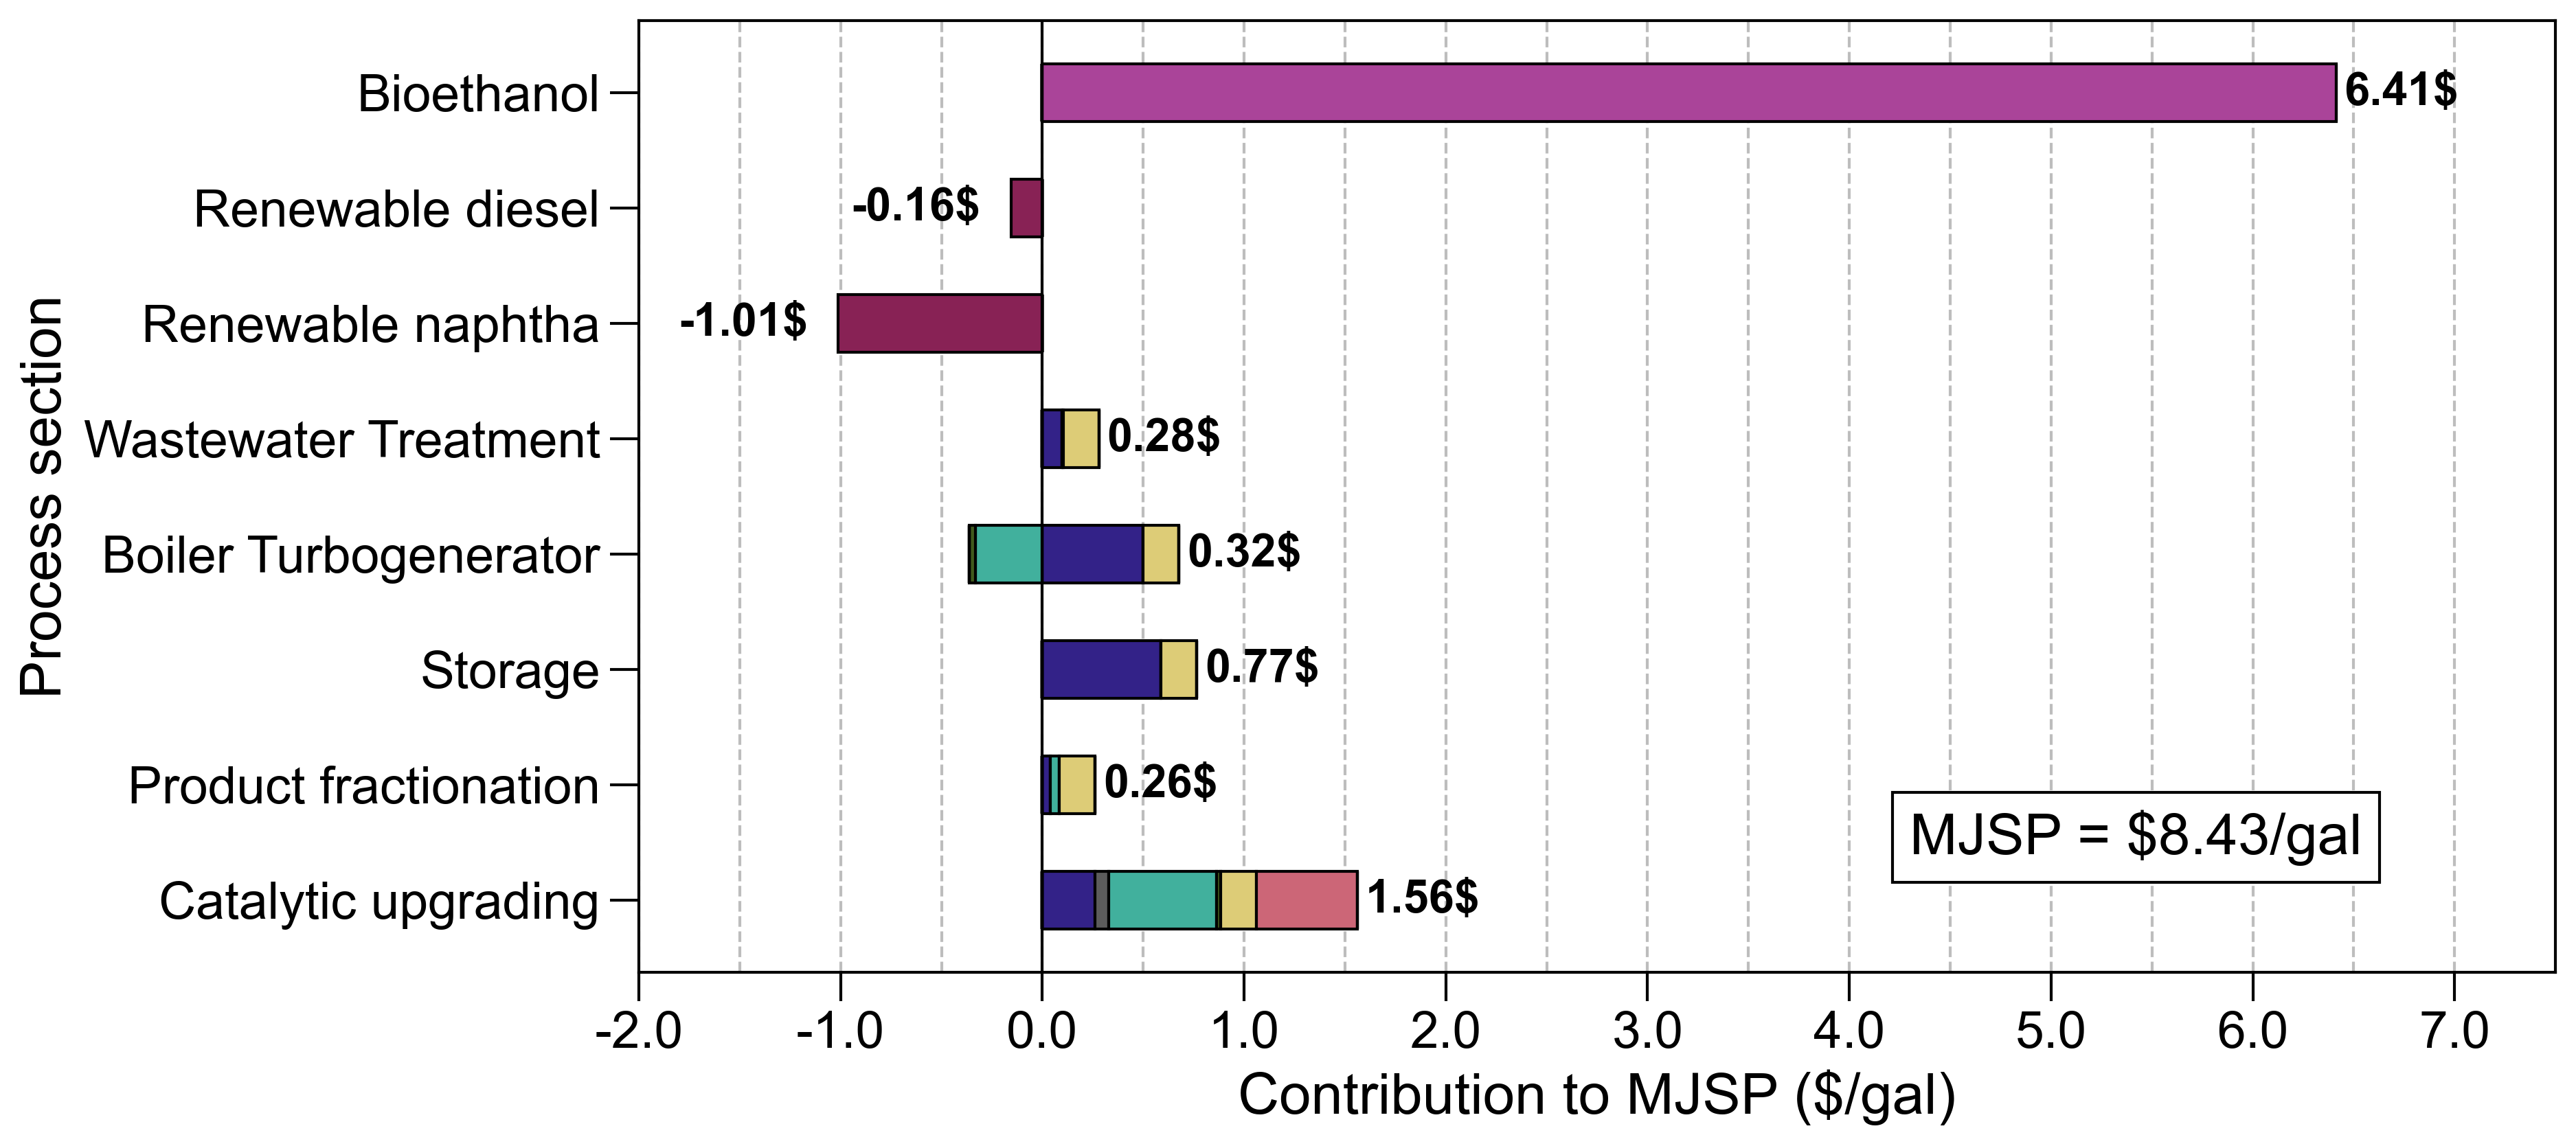

In [36]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='Arial')

fig, ax = plt.subplots(figsize=(12, 6))

custom_colors = [
    '#332288',  # Installed costs
    "#5C5C5C",  # Catalyst replacement
    "#41B09D",  # Utilities excl. electricity
    "#415A1D",  # Process electricity
    '#DDCC77',  # Fixed costs
    '#CC6677',  # Hydrogen
    '#AA4499',  # Ethanol
    '#882255',  # Co-product
]

# two separate “bottoms”
bottom_pos = np.zeros(len(bar_categories))  # for >= 0
bottom_neg = np.zeros(len(bar_categories))  # for < 0

for i, (cost, label) in enumerate(zip(costs, legend_categories)):
    cost = np.asarray(cost)

    pos = np.where(cost > 0, cost, 0)
    neg = np.where(cost < 0, cost, 0)

    # positive part
    ax.barh(
        bar_categories, pos, left=bottom_pos,
        color=custom_colors[i], edgecolor='black', linewidth=1, height=0.5,
        label=label  # legend
    )
    bottom_pos += pos

    # negative part
    ax.barh(
        bar_categories, neg, left=bottom_neg,
        color=custom_colors[i], edgecolor='black', linewidth=1, height=0.5
    )
    bottom_neg += neg
    



# Add labels and legend
ax.set_xlabel('Contribution to MJSP ($/gal)', fontsize = 20)
ax.set_ylabel('Process section', fontsize = 20)
#ax.legend(title="Cost Category", bbox_to_anchor=(1.05, 1), loc='upper left')


ax.tick_params(axis='both', which='major', labelsize=18, width=1, length=10)
# set the axis line width in pixels
for axis in 'left', 'bottom', 'top', 'right':
  ax.spines[axis].set_linewidth(1)

# Add a vertical line at x=0
ax.axvline(0, color='black', linewidth=1)

# Set the x positions for the vertical lines (for example, every 0.2 units from -1 to 1)
xlines = np.arange(-2, 7.5, 0.5)  # adjust range and step as needed

for x in xlines:
    ax.axvline(x, color='#bdbdbd', linestyle='--', linewidth=1, zorder=0)


# Define the range for x-axis ticks
min_tick = np.floor(bottom_neg.min())     # negative extent
max_tick = np.ceil(bottom_pos.max())      # positive extent
step = 1.0



# Add some padding if desired
ax.set_xlim(min_tick - 0.5, max_tick + 0.5)
# Create ticks at -1.0, 0.0, 1.0, ...
xticks = np.arange(min_tick, max_tick + step, step)
ax.set_xticks(xticks)
ax.set_xticklabels([f"{x:.1f}" for x in xticks], fontsize=18)
ax.set_xlim(-2, 7.5)


# Totals per bar
net_totals = costs.sum(axis=0)                         # net contribution
pos_totals = np.clip(costs, 0, None).sum(axis=0)       # sum of >= 0 parts
neg_totals = np.clip(costs, None, 0).sum(axis=0)       # sum of < 0 parts (negative)

for i, (category, net, pos, neg) in enumerate(
        zip(bar_categories, net_totals, pos_totals, neg_totals)):
    
    if net >= 0:
        # place label just to the right of the rightmost positive stack
        xpos = pos + 0.04
        ha = 'left'
    else:
        # place label just to the left of the leftmost negative stack
        xpos = neg - 0.15
        ha = 'right'
    
    ax.text(
        xpos, i,
        f"{net:.2f}$",
        va='center',
        ha=ha,
        fontsize=16,
        fontweight='bold'
    )

ax.text(
    4.3, 0.4,  # x, y position; adjust as needed
    f"MJSP = ${mjsp:.2f}/gal",
    fontsize=20,
    color='black',
    bbox=dict(
        facecolor='white',
        edgecolor='black',
        linewidth=1,         # Thicker box border
        boxstyle='square,pad=0.3'  # Sharp edges
    )
)


#plt.tight_layout() 
# plt.savefig('cost_breakdown.png', bbox_inches = 'tight')
#plt.show()

In [37]:
final_tea.TCI

103299006.7353461

#   Uncertainty analysis 

In [38]:
model = bst.Model(atj_sys)

In [39]:
from chaospy import distributions as shape
param = model.parameter

In [40]:
price_data['dehydration_catalyst'] 

36.81

In [41]:
dehyd_1.catalyst_price

36.81

In [42]:
# Uncertainty parameters for dehydration of ethanol to ethylene

# Dehydration P
dist = shape.Triangle(lower = 980665, midpoint = 1063000, upper = 1569064)
@param(name = 'Dehydration pressure',
#       element = 'ATJ-TEA',
       kind = 'coupled',
       units = 'Pa',
       baseline = 1063000, distribution = dist)
def set_dehyd_P(i):
    dehyd_1.pressure = i


# Dehydration T
dist = shape.Triangle(lower = 743.15, midpoint = dehyd_data['temp'], upper = 758.15)
@param(name = 'Dehydration temperature',
#       element = 'ATJ-TEA',
       kind = 'coupled',
       units = 'K',
       baseline = dehyd_data['temp'], distribution = dist)
def set_dehyd_T(i):
    dehyd_1.temperature = i


# Dehydration WHSV
dist = shape.Triangle(lower = 0.25, midpoint = 0.3, upper = 0.35) 
@param(name = 'Dehydration WHSV',
#     element = 'ATJ-TEA', 
       kind = 'coupled',
       units = '/h',
       baseline = 0.3, distribution = dist)
def set_dehyd_WHSV(i):
    dehyd_1.WHSV = i  


# Dehydration catalyst price
dist = shape.Triangle(lower = price_data['dehydration_catalyst']*0.5,  midpoint = price_data['dehydration_catalyst'], upper = price_data['dehydration_catalyst']*1.5)
@param(name = 'Dehydration catalyst price',
  #     element = 'ATJ-TEA',
       kind = 'isolated',
       units = 'USD/kg',
       baseline = price_data['dehydration_catalyst'], distribution = dist)
def set_dehydration_catalyst_price(i): 
    dehyd_1.catalyst_price = i   
    F.Dehyd_cat_replacement.price = i

# Dehydration catalyst lifetime
dist = shape.Triangle(lower = 1,  midpoint = 2, upper = 3)
@param(name = 'Dehydration catalyst lifetime',
  #     element = 'ATJ-TEA',
       kind = 'isolated',
       units = 'yr',
       baseline = 2, distribution = dist)
def set_dehydration_catalyst_lifetime(i): 
    dehyd_1.catalyst_lifetime = i    
      

In [43]:
# Uncertainty parameters for ethylene oligomerization


# Oligomerization P
dist = shape.Triangle(lower = olig_data['pressure']*0.8, midpoint = olig_data['pressure'], upper = olig_data['pressure']*1.2) # Range from the patent
@param(name = 'Oligomerization pressure',
    # element = 'ATJ-TEA', 
       kind = 'coupled',
       units = 'Pa',
       baseline = olig_data['pressure'], distribution = dist)
def set_olig_P(i):
    olig_1.pressure = i

# Oligomerization T
dist = shape.Triangle(lower = olig_data['temp']*0.8, midpoint = olig_data['temp'], upper = olig_data['temp']*1.2) # Range from the patent
@param(name = 'Oliomerization temperature',
#     element = 'ATJ-TEA', 
       kind = 'coupled',
       units = 'K',
       baseline = olig_data['temp'], distribution = dist)
def set_olig_T(i):
   olig_1.temperature = i


# Oligomerization WHSV
dist = shape.Triangle(lower = olig_data['whsv']*0.8, midpoint = olig_data['whsv'], upper = olig_data['whsv']*1.2) # Range from the patent
@param(name = 'Oligomerization WHSV',
     #element = 'ATJ-TEA', 
       kind = 'coupled',
       units = '/h',
       baseline = olig_data['whsv'], distribution = dist)
def set_olig_WHSV(i):
    olig_1.WHSV = i


# Oligomerization conversion
dist = shape.Triangle(lower = 0.8, midpoint = olig_data['conv'], upper =  olig_data['conv']) 
@param(name = 'Oligomerization conversion',
     #element = 'ATJ-TEA', 
       kind = 'coupled',
       units = '%',
       baseline = olig_data['conv'], distribution = dist)
def set_olig_conv(i):
    olig_1.conversion = i


# Oligomerization catalyst price
dist = shape.Triangle(lower = price_data['oligomerization_catalyst']*0.5,  midpoint = price_data['oligomerization_catalyst'], upper = price_data['oligomerization_catalyst']*1.5)
@param(name = 'oligomerization catalyst',
  #     element = 'ATJ-TEA',
       kind = 'isolated',
       units = 'USD/kg',
       baseline = price_data['oligomerization_catalyst'], distribution = dist)
def set_oligomerization_catalyst_price(i): 
    olig_1.catalyst_price = i
    F.Olig_cat_replacement.price = i


# Oligomerization catalyst lifetime
dist = shape.Uniform(lower = 0.5 , upper = 2)
@param(name = 'oligomerization catalyst lifetime',
  #     element = 'ATJ-TEA',
       kind = 'isolated',
       units = 'yr',
       baseline = 1, distribution = dist)
def set_oligomerization_catalyst_price(i): 
    olig_1.catalyst_lifetime = i



In [44]:
# Hydrogenation uncertainty parameters

# Hydrogenation Catalyst price
dist = shape.Triangle(lower = price_data['hydrogenation_catalyst']*0.5,  midpoint = price_data['hydrogenation_catalyst'], upper = price_data['hydrogenation_catalyst']*1.5)
@param(name = 'Hydrogenation catalyst price',
     #  element = 'ATJ-TEA',
       kind = 'isolated',
       units = 'USD/kg',
       baseline = price_data['hydrogenation_catalyst'], distribution = dist)
def set_hydrogenation_catalyst_price(i): 
    hydgn_1.catalyst_price = i


# Hydrogenation Catalyst lifetime
dist = shape.Triangle(lower = 2.5,  midpoint = 3, upper = 3.5)
@param(name = 'Hydrogenation catalyst lifetime',
     #  element = 'ATJ-TEA',
       kind = 'isolated',
       units = 'yr',
       baseline = 3, distribution = dist)
def set_hydrogenation_catalyst_lifetime(i): 
    hydgn_1.catalyst_lifetime = i    
    F.Hydgn_cat_replacement.price = i


In [45]:

    #tea = cls(
    #    system=sys, 
    #    IRR=0.1, 
    #    duration=(2023, 2053),
    #    depreciation='MACRS7', 
    #    income_tax=0.21,
    #    operating_days=330,
    #    lang_factor=None, 
    #    construction_schedule=(0.08, 0.60, 0.32),
    #    startup_months=3, 
    #    startup_FOCfrac=1,
    #    startup_salesfrac=0.5,
    #    startup_VOCfrac=0.75,
    #    WC_over_FCI=0.05,
    #    finance_interest=0.08,
    #    finance_years=10,
    #    finance_fraction=0.6,
    #    OSBL_units=OSBL_units,
    #    warehouse=0.04, 
    #    site_development=0.09, 
    #    additional_piping=0.045,
    #    proratable_costs=0.10,
    #    field_expenses=0.10,
    #    construction=0.20,
    #    contingency=0.10,
    #    other_indirect_costs=0.10, 
    #    labor_cost=2.5e6,
    #    labor_burden=0.90,
    #    property_insurance=0.007, 
    #    maintenance=0.03,

In [46]:
# Maintenance
dist = shape.Uniform(lower = final_tea.maintenance*0.8, upper = final_tea.maintenance*1.2)
@param(name = 'Maintenance',
      # element = 'ATJ-TEA',
       kind = 'isolated',
       units = 'USD/yr',
       baseline = final_tea.maintenance, distribution = dist)
def set_maintenance(i): 
    final_tea.maintenance = i


# Property insurance
dist = shape.Triangle(lower = final_tea.property_insurance*0.8,  midpoint = final_tea.property_insurance, upper = final_tea.property_insurance*1.2)
@param(name = 'Property insurance',
      # element = 'ATJ-TEA',
       kind = 'isolated',
       units = 'USD/yr',
       baseline = final_tea.property_insurance, distribution = dist)
def set_property_insurance(i): 
    final_tea.property_insurance = i


# Labor burden
dist = shape.Triangle(lower = final_tea.labor_burden*0.8,  midpoint = final_tea.labor_burden, upper = final_tea.labor_burden*1.2)
@param(name = 'Labor burden',
      # element = 'ATJ-TEA',
       kind = 'isolated',
       units = 'USD/yr',
       baseline = final_tea.labor_burden, distribution = dist)
def set_labor_burden(i): 
    final_tea.labor_burden = i    



# Labor cost
dist = shape.Triangle(lower = final_tea.labor_cost*0.8,  midpoint = final_tea.labor_cost, upper = final_tea.labor_cost*1.2)
@param(name = 'Labor cost',
      # element = 'ATJ-TEA',
       kind = 'isolated',
       units = 'USD/yr',
       baseline = final_tea.labor_cost, distribution = dist)
def set_labor_cost(i): 
    final_tea.labor_cost = i        

# Other indirect costs
dist = shape.Triangle(lower = final_tea.other_indirect_costs*0.8,  midpoint = final_tea.other_indirect_costs, upper = final_tea.other_indirect_costs*1.2)
@param(name = 'Other indirect costs',
      # element = 'ATJ-TEA',
       kind = 'isolated',
       units = 'USD/yr',
       baseline = final_tea.other_indirect_costs, distribution = dist)
def set_maintenance(i): 
    final_tea.other_indirect_costs = i


# Contingency
dist = shape.Triangle(lower = final_tea.contingency*0.8,  midpoint = final_tea.contingency, upper = final_tea.contingency*1.2)
@param(name = 'Contingency',
      # element = 'ATJ-TEA',
       kind = 'isolated',
       units = 'USD/yr',
       baseline = final_tea.contingency, distribution = dist)
def set_contingency(i): 
    final_tea.contingency = i


# Construction
dist = shape.Triangle(lower = final_tea.construction*0.8,  midpoint = final_tea.construction, upper = final_tea.construction*1.2)
@param(name = 'Construction',
      # element = 'ATJ-TEA',
       kind = 'isolated',
       units = 'USD/yr',
       baseline = final_tea.construction, distribution = dist)
def set_construction(i): 
    final_tea.construction = i


# Field expenses
dist = shape.Triangle(lower = final_tea.field_expenses*0.8,  midpoint = final_tea.field_expenses, upper = final_tea.field_expenses*1.2)
@param(name = 'Field expenses',
      # element = 'ATJ-TEA',
       kind = 'isolated',
       units = 'USD/yr',
       baseline = final_tea.field_expenses, distribution = dist)
def set_field_expenses(i): 
    final_tea.field_expenses = i
#
# Proratable costs
dist = shape.Triangle(lower = final_tea.proratable_costs*0.8,  midpoint = final_tea.proratable_costs, upper = final_tea.proratable_costs*1.2)
@param(name = 'Proratable costs',
      # element = 'ATJ-TEA',
       kind = 'isolated',
       units = 'USD/yr',
       baseline = final_tea.proratable_costs, distribution = dist)
def set_proratable_costs(i): 
    final_tea.proratable_costs = i



# Additional piping
dist = shape.Triangle(lower = final_tea.additional_piping*0.8,  midpoint = final_tea.additional_piping, upper = final_tea.additional_piping*1.2)
@param(name = 'Additional piping costs',
      # element = 'ATJ-TEA',
       kind = 'isolated',
       units = 'USD/yr',
       baseline = final_tea.additional_piping, distribution = dist)
def set_additional_piping_costs(i): 
    final_tea.additional_piping = i


    
# Site development
dist = shape.Triangle(lower = final_tea.site_development*0.8,  midpoint = final_tea.site_development, upper = final_tea.site_development*1.2)
@param(name = 'Site development costs',
      # element = 'ATJ-TEA',
       kind = 'isolated',
       units = 'USD/yr',
       baseline = final_tea.site_development, distribution = dist)
def set_site_development_costs(i): 
    final_tea.site_development = i


# Warehouse
dist = shape.Triangle(lower = final_tea.warehouse*0.8,  midpoint = final_tea.warehouse, upper = final_tea.warehouse*1.2)
@param(name = 'Warehouse costs',
      # element = 'ATJ-TEA',
       kind = 'isolated',
       units = 'USD/yr',
       baseline = final_tea.warehouse, distribution = dist)
def set_warehouse_costs(i): 
    final_tea.warehouse = i    

# Finance fraction
dist = shape.Triangle(lower = final_tea.finance_fraction*0.8,  midpoint = final_tea.finance_fraction, upper = final_tea.finance_fraction*1.2)
@param(name = 'Finance fraction',
      # element = 'ATJ-TEA',
       kind = 'isolated',
       units = 'USD/yr',
       baseline = final_tea.finance_fraction, distribution = dist)
def set_finance_fraction(i): 
    final_tea.finance_fraction = i    

#
## Finance years
#dist = shape.Triangle(lower = final_tea.finance_years*0.8,  midpoint = final_tea.finance_years, upper = final_tea.finance_years*1.2)
#@param(name = 'Finance years',
#      # element = 'ATJ-TEA',
#       kind = 'isolated',
#       units = 'USD/yr',
#       baseline = final_tea.finance_years, distribution = dist)
#def set_finance_years(i): 
#    final_tea.finance_years = i    
#

# Finance interest
dist = shape.Triangle(lower = final_tea.finance_interest*0.8,  midpoint = final_tea.finance_interest, upper = final_tea.finance_interest*1.2)
@param(name = 'Finance interest',
      # element = 'ATJ-TEA',
       kind = 'isolated',
       units = 'USD/yr',
       baseline = final_tea.finance_interest, distribution = dist)
def set_finance_interest(i): 
    final_tea.finance_interest = i    

#
#

# Working capital over FCI
dist = shape.Triangle(lower = final_tea.WC_over_FCI*0.8,  midpoint = final_tea.WC_over_FCI, upper = final_tea.WC_over_FCI*1.2)
@param(name = 'Working capital over FCI',
      # element = 'ATJ-TEA',
       kind = 'isolated',
       units = 'USD/yr',
       baseline = final_tea.WC_over_FCI, distribution = dist)
def set_WC_over_FCI(i): 
    final_tea.WC_over_FCI = i        
#
# Startup variable operating costs fraction
dist = shape.Triangle(lower = final_tea.startup_VOCfrac*0.8,  midpoint = final_tea.startup_VOCfrac, upper = final_tea.startup_VOCfrac*1.2)
@param(name = 'Startup VOC fraction',
      # element = 'ATJ-TEA',
       kind = 'isolated',
       units = 'USD/yr',
       baseline = final_tea.startup_VOCfrac, distribution = dist)
def set_startup_VOC_frac(i): 
    final_tea.startup_VOCfrac = i       


# Startup sales fraction
dist = shape.Triangle(lower = final_tea.startup_salesfrac*0.8,  midpoint = final_tea.startup_salesfrac, upper = final_tea.startup_salesfrac*1.2)
@param(name = 'Startup Sales fraction',
      # element = 'ATJ-TEA',
       kind = 'isolated',
       units = 'USD/yr',
       baseline = final_tea.startup_salesfrac, distribution = dist)
def set_startup_sales_frac(i): 
    final_tea.startup_salesfrac = i       


# Startup FOC fraction
dist = shape.Triangle(lower = final_tea.startup_FOCfrac*0.8,  midpoint = final_tea.startup_FOCfrac, upper = final_tea.startup_FOCfrac*1.2)
@param(name = 'Startup FOC fraction',
      # element = 'ATJ-TEA',
       kind = 'isolated',
       units = 'USD/yr',
       baseline = final_tea.startup_FOCfrac, distribution = dist)
def set_startup_FOC_frac(i): 
    final_tea.startup_FOCfrac = i   
#
# Startup months
dist = shape.Uniform(lower = 1, upper = 12) # Uncertainty how long it takes to startup
@param(name = 'Startup months',
      # element = 'ATJ-TEA',
       kind = 'isolated',
       units = 'USD/yr',
       baseline = final_tea.startup_months, distribution = dist)
def set_startup_months(i): 
    final_tea.startup_months = i   
#


# Income tax
dist = shape.Triangle(lower = final_tea.income_tax*0.8,  midpoint = final_tea.income_tax, upper = final_tea.income_tax*1.2)
@param(name = 'Income tax',
      # element = 'ATJ-TEA',
       kind = 'isolated',
       units = 'USD/yr',
       baseline = final_tea.income_tax, distribution = dist)
def get_income_tax(i): 
    final_tea.income_tax = i   

#    

In [47]:
final_tea.warehouse

0.04

In [48]:
# Operating days
dist = shape.Triangle(lower = final_tea.operating_days*0.9, midpoint = final_tea.operating_days, upper = final_tea.operating_days*1.1)
@param(name = 'Operating days',
   #    element = 'ATJ_TEA',
       kind = 'isolated',
       units = 'USD',
       baseline = final_tea.operating_days, distribution = dist)
def set_operating_days(i):
    final_tea.operating_days = i

In [49]:
# Utility prices

# Chilled brine heat transfer price
dist = shape.Triangle(lower = bst.settings.get_agent('chilled_brine').heat_transfer_price*0.8, midpoint =  bst.settings.get_agent('chilled_brine').heat_transfer_price, upper = bst.settings.get_agent('chilled_brine').heat_transfer_price*1.2)
@param(name = 'Chilled Brine Price',
  #     element = 'ATJ_TEA',
       kind = 'isolated',
       units = 'USD/kJ',
       baseline = bst.settings.get_agent('chilled_brine').heat_transfer_price, distribution = dist)
def set_chilled_brine_price(i):
    bst.settings.get_agent('chilled_brine').heat_transfer_price = i

# Chilled Water heat transfer price
dist = shape.Triangle(lower = bst.settings.get_agent('chilled_water').heat_transfer_price*0.8, midpoint =  bst.settings.get_agent('chilled_water').heat_transfer_price, upper = bst.settings.get_agent('chilled_water').heat_transfer_price*1.2)
@param(name = 'Chilled Water Price',
   #    element = 'ATJ_TEA',
       kind = 'isolated',
       units = 'USD/kJ',
       baseline = bst.settings.get_agent('chilled_water').heat_transfer_price, distribution = dist)
def set_chilled_water_price(i):
    bst.settings.get_agent('chilled_water').heat_transfer_price = i

# Cooling Water regeneration price
dist = shape.Triangle(lower = bst.settings.get_agent('cooling_water').regeneration_price*0.8, midpoint =  bst.settings.get_agent('cooling_water').regeneration_price, upper = bst.settings.get_agent('cooling_water').regeneration_price*1.2)
@param(name = 'Cooling Water Price',
  #     element = 'ATJ_TEA',
       kind = 'isolated',
       units = 'USD/kJ',
       baseline = bst.settings.get_agent('cooling_water').regeneration_price, distribution = dist)
def set_cooling_water_price(i):
    bst.settings.get_agent('cooling_water').regeneration_price = i

# High pressure steam regeneration price
dist = shape.Triangle(lower = bst.settings.get_agent('high_pressure_steam').regeneration_price*0.8, midpoint =  bst.settings.get_agent('high_pressure_steam').regeneration_price,upper = bst.settings.get_agent('high_pressure_steam').regeneration_price*1.2)
@param(name = 'HP Steam Price',
    #   element = 'ATJ_TEA',
       kind = 'isolated',
       units = 'USD/kmol',
       baseline = bst.settings.get_agent('high_pressure_steam').regeneration_price, distribution = dist)
def set_high_pressure_steam_price(i):
    bst.settings.get_agent('high_pressure_steam').regeneration_price = i

# Medium pressure steam regeneration price
dist = shape.Triangle(lower = bst.settings.get_agent('medium_pressure_steam').regeneration_price*0.8, midpoint =  bst.settings.get_agent('medium_pressure_steam').regeneration_price,upper = bst.settings.get_agent('medium_pressure_steam').regeneration_price*1.2)
@param(name = 'MP Steam Price',
  #     element = 'ATJ_TEA',
       kind = 'isolated',
       units = 'USD/kmol',
       baseline = bst.settings.get_agent('medium_pressure_steam').regeneration_price, distribution = dist)
def set_medium_pressure_steam_price(i):
    bst.settings.get_agent('medium_pressure_steam').regeneration_price = i


# Low pressure steam regeneration price
dist = shape.Triangle(lower = bst.settings.get_agent('low_pressure_steam').regeneration_price*0.8, midpoint =  bst.settings.get_agent('low_pressure_steam').regeneration_price,upper = bst.settings.get_agent('low_pressure_steam').regeneration_price*1.2)
@param(name = 'LP Steam Price',
  #     element = 'ATJ_TEA',
       kind = 'isolated',
       units = 'USD/kmol',
       baseline = bst.settings.get_agent('low_pressure_steam').regeneration_price, distribution = dist)
def set_low_pressure_steam_price(i):
    bst.settings.get_agent('low_pressure_steam').regeneration_price = i

# Natural gas regeneration price
dist = shape.Triangle(lower = bst.settings.get_agent('natural_gas').regeneration_price*0.8, midpoint =  bst.settings.get_agent('natural_gas').regeneration_price, upper = bst.settings.get_agent('natural_gas').regeneration_price*1.2)
@param(name = 'Natural Gas Price',
  #     element = 'ATJ_TEA',
       kind = 'isolated',
       units = 'USD/kmol',
       baseline = bst.settings.get_agent('natural_gas').regeneration_price, distribution = dist)
def set_natural_gas_price(i):
    bst.settings.get_agent('natural_gas').regeneration_price = i




In [50]:
# Electricity price
dist = shape.Triangle(lower = 0.033,  midpoint = bst.PowerUtility.price , upper = 0.20)
@param(name = 'electricity price',
 #      element = 'ATJ-TEA',
       kind = 'isolated',
       units = 'USD/kWh',
       baseline = bst.PowerUtility.price, distribution = dist)
def set_electricity_price(i): 
    bst.PowerUtility.price = i


# Ethanol price
dist = shape.Triangle(lower = ethanol_price_converter(1.25), midpoint = etoh_in.price , upper = ethanol_price_converter(4.2))
@param(name = 'feedstock price',
  #     element = 'ATJ-TEA',
       kind = 'isolated',
       units = 'USD/kg',
       baseline = etoh_in.price, distribution = dist)
def set_etoh_in_price(i):
    etoh_in.price = i


# Hydrogen price
dist = shape.Uniform(lower = 3.7, upper = 12.12)
@param(name = 'hydrogen price',
   #    element = 'ATJ-TEA',
       kind = 'isolated',
       units = 'USD/kg',
       baseline = price_data['hydrogen'], distribution = dist)
def set_h2_price(i): 
    price_data['hydrogen'] = i


# Renewable diesel price
dist = shape.Uniform(lower = 0.92, upper = 2.14)
@param(name = 'renewable diesel price',
    #   element = 'ATJ-TEA',
       kind = 'isolated',
       units = 'USD/kg',
       baseline = price_data['renewable_diesel'], distribution = dist)
def set_renewable_diesel_price(i):
    F.RD.price = i

# Renewable naphtha price
dist = shape.Uniform(lower = 0.55, upper = 1)
@param(name = 'renewable naphtha price',
    #   element = 'ATJ-TEA',
       kind = 'isolated',
       units = 'USD/kg',
       baseline = price_data['renewable_naphtha'], distribution = dist)
def set_renewable_naphtha_price(i): 
    F.RD.price = i




In [51]:
metric = model.metric
@metric(name = 'Minimum Jet Selling Price', units = 'USD/gal', element = 'ATJ-TEA')
def get_msp():
    msp = (final_tea.solve_price(F.SAF)*F.SAF.rho)/264.172
    return msp

In [52]:
import numpy as np
np.random.seed(3029)
samples = model.sample(N=3000, rule = 'L')  # Change this to 3000 later
model.load_samples(samples)

In [53]:
model.evaluate(convergence_model = 'Average')

c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\biosteam\units\design_tools\pressure_vessel.py:104: CostWarning: <Flash: T201> Vertical vessel weight (860.9 lb) is out of bounds (4200 to 1e+06 lb) for cost correlation
  return method(pressure, diameter, length)
c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\biosteam\units\design_tools\pressure_vessel.py:104: CostWarning: <Flash: T201> Vertical vessel length (6.5 ft) is out of bounds (12 to 40 ft) for cost correlation
  return method(pressure, diameter, length)
c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\biosteam\_unit.py:1241: CostWarning: <IsentropicCompressor: K202> power (122.4 hp) is out of bounds (200 to 3e+04 hp) for cost correlation
  self._cost(**cost_kwargs) if cost_kwargs else self._cost()
c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\biosteam\units\design_tools\pressure_vessel.py:104: CostWarning: <RefluxDrum: reflux_drum> Vertical vessel weight (751.3 lb) is out of bounds (4200 to 1e+06 lb

In [54]:
msp_values = model.table["ATJ-TEA", "Minimum jet selling price [USD/gal]"]
msp_values


,ATJ-TEA
,Minimum jet selling price [USD/gal]
0,7.06
1,7.66
2,9.37
3,10.2
4,7.35
...,...
2995,10.1
2996,9.2
2997,6.34


In [55]:
# model.table.to_excel('uncertainty_analysis_result.xlsx')

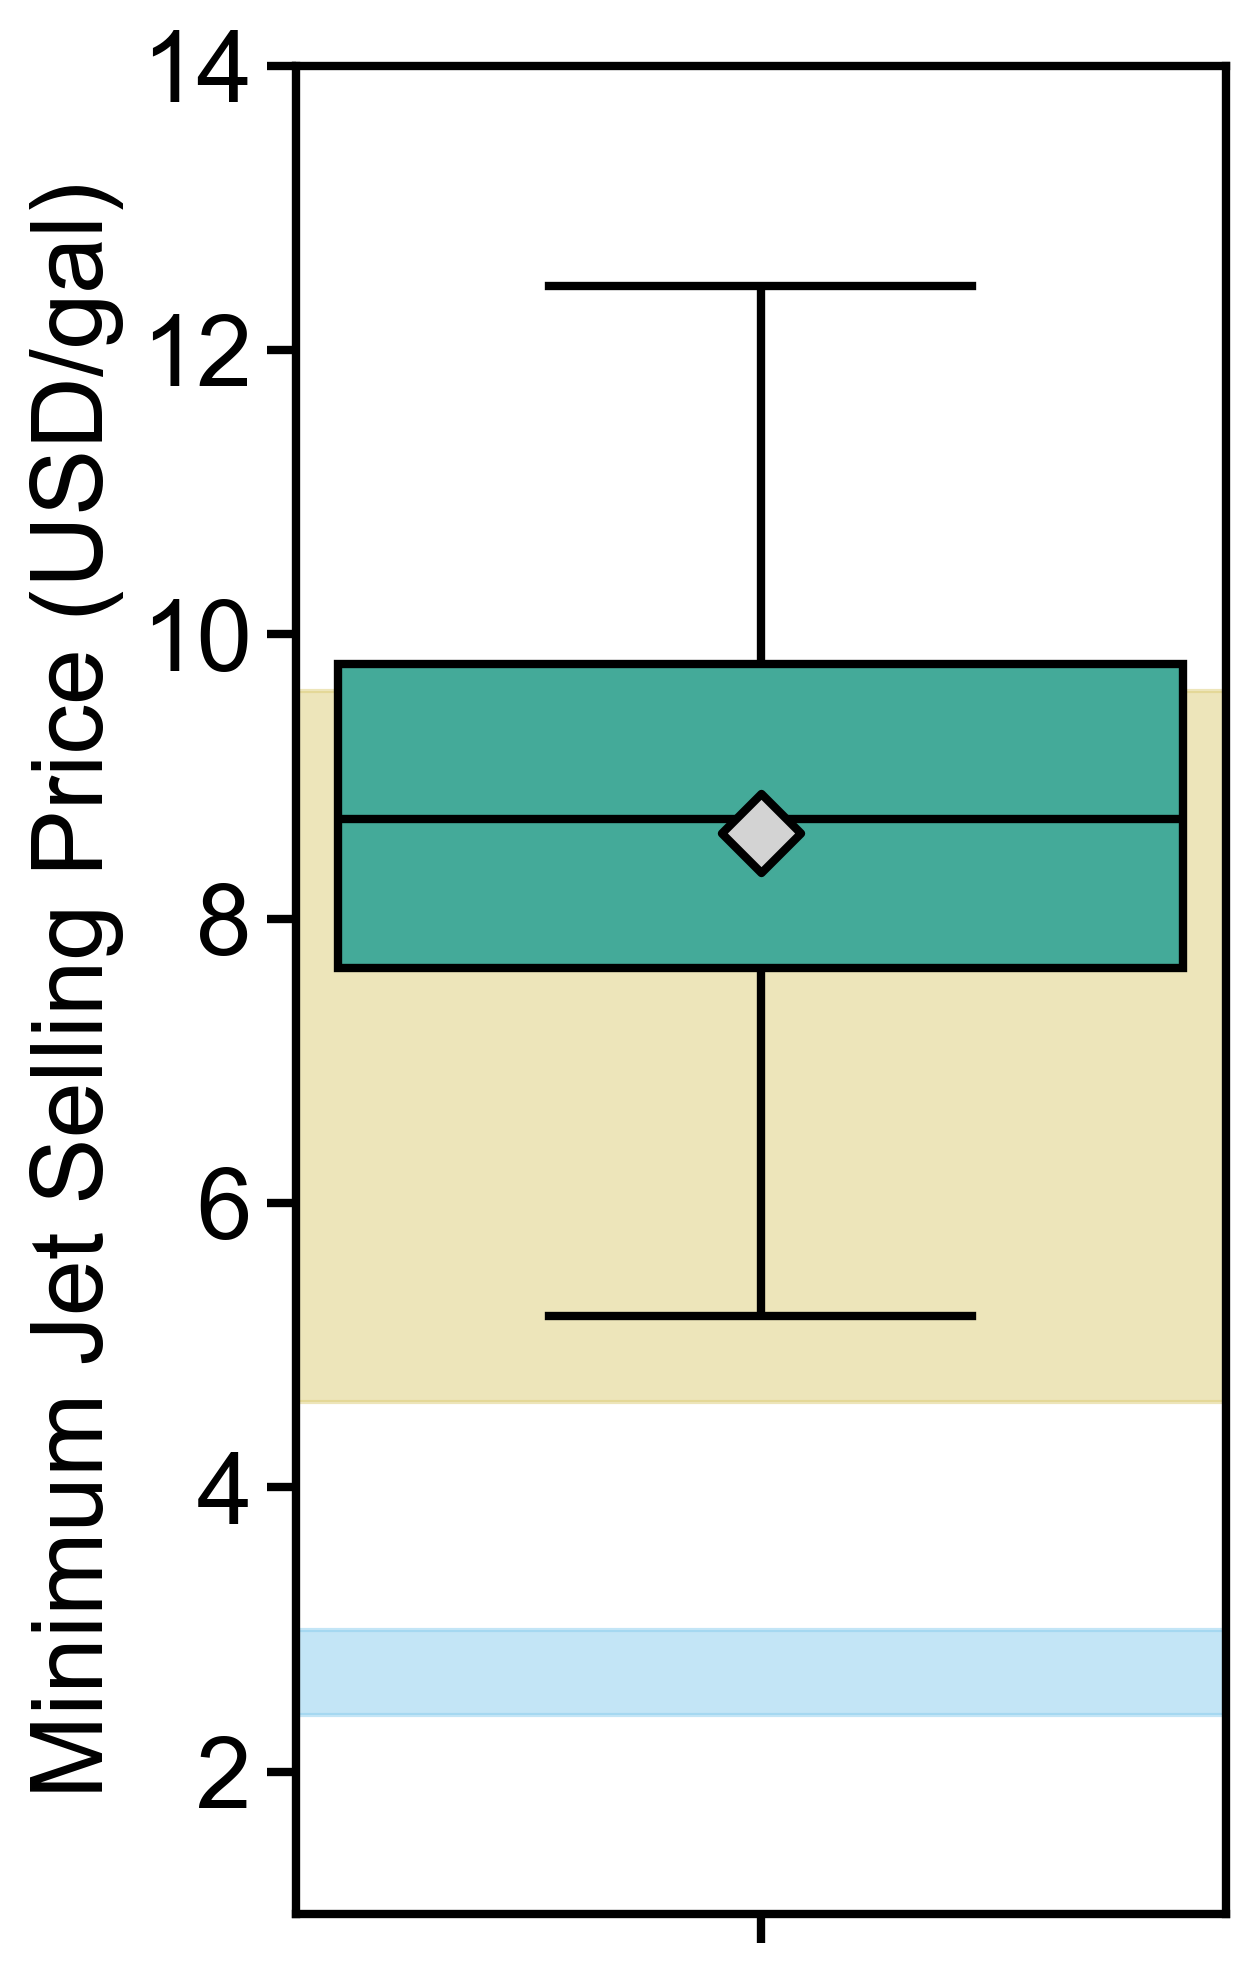

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font',family='Arial')

msp_values = model.table["ATJ-TEA", "Minimum jet selling price [USD/gal]"]
msp_df = pd.DataFrame({'MSP ($/gal)': msp_values})
plt.figure(figsize=(4, 8))  # Adjust figure size

# Way to fetch a color palette from seaborn
bugn = sns.color_palette('BuGn', n_colors=6)  # Get 6 shades of blue
light_bugn = bugn[2]
mid_bugn = bugn[4]
dark_bugn = bugn[5]
'''
# Create the violin plot with embedded box plot
sns.violinplot(
    data=msp_df,
    y="MSP ($/gal)",
    inner="box",
    color="#c6dbef",  # Violin body color (HEX)
    linewidth=0
)

'''

sns.boxplot(
    data=msp_df,
    y="MSP ($/gal)",
    width=0.20,
    boxprops={"facecolor": "#44AA99", "edgecolor": 'black', "linewidth": 2},
    medianprops={"color": "black", "linewidth": 2},
    whiskerprops={"color": "black", "linewidth": 2},
    capprops={"color": "black", "linewidth": 2}
)



# Add gray diamond marker at 8.6
ax = plt.gca()
ax.scatter(
    x=0, y=8.6,  # x=0 for single-category violin/box plot
    marker='D',  # Diamond marker
    s=180,       # Size of the marker
    facecolor='lightgray',
    edgecolor='black',
    linewidth=2,
    zorder=10
)


plt.tick_params(axis='both', which='major', labelsize=24, width=2.0, length=7)
# set the axis line width in pixels
ax = plt.gca()  # Get current axes
for axis in ['left', 'bottom', 'top', 'right']:
    ax.spines[axis].set_linewidth(2.0)
    ax.set_ylim(1, 14)
plt.yticks(fontsize = 24, color = 'black')


# Label the plot
plt.ylabel("Minimum Jet Selling Price (USD/gal)", fontsize=24, color = 'black')
#plt.title(f'Capacity: {round((saf_stream.F_vol*264.17*24*330)/1e6,1)} MM gal/yr', fontsize=16, color = 'black')
#plt.grid(True, 'major', 'y', linestyle="--", linewidth=1.2, alpha=0.5, color = 'gray')


# Add shaded area from 2.4 to 3 USD/gal
ax.axhspan(2.4, 3.0, color='#88CCEE', alpha=0.5, zorder=0)

# Add shaded area from 4.4 
ax.axhspan(4.6, 9.6, color='#DDCC77', alpha=0.5, zorder=0)

# Saving the plot
#plt.savefig("msp_violin_plot.png", dpi=300, bbox_inches="tight")  # PNG format (high quality)
# Show the plot

plt.savefig("box_plot.png", bbox_inches="tight")
plt.show()

In [57]:
df_rho, df_p = model.spearman_r()
print(df_rho["ATJ-TEA", "Minimum jet selling price [USD/gal]"])

Element  Parameter                             
-        Dehydration pressure [Pa]                 -0.00771
         Dehydration temperature [K]                0.00968
         Dehydration WHSV [/h]                      -0.0101
         Dehydration catalyst price [USD/kg]          0.035
         Dehydration catalyst lifetime [yr]          0.0213
         Oligomerization pressure [Pa]             -0.00387
         Oliomerization temperature [K]             0.00472
         Oligomerization WHSV [/h]                  -0.0318
         Oligomerization conversion [%]            -0.00814
         Oligomerization catalyst [USD/kg]          -0.0205
         Oligomerization catalyst lifetime [yr]      0.0226
         Hydrogenation catalyst price [USD/kg]      -0.0305
         Hydrogenation catalyst lifetime [yr]        0.0153
         Maintenance [USD/yr]                       -0.0168
         Property insurance [USD/yr]                -0.0459
         Labor burden [USD/yr]                      

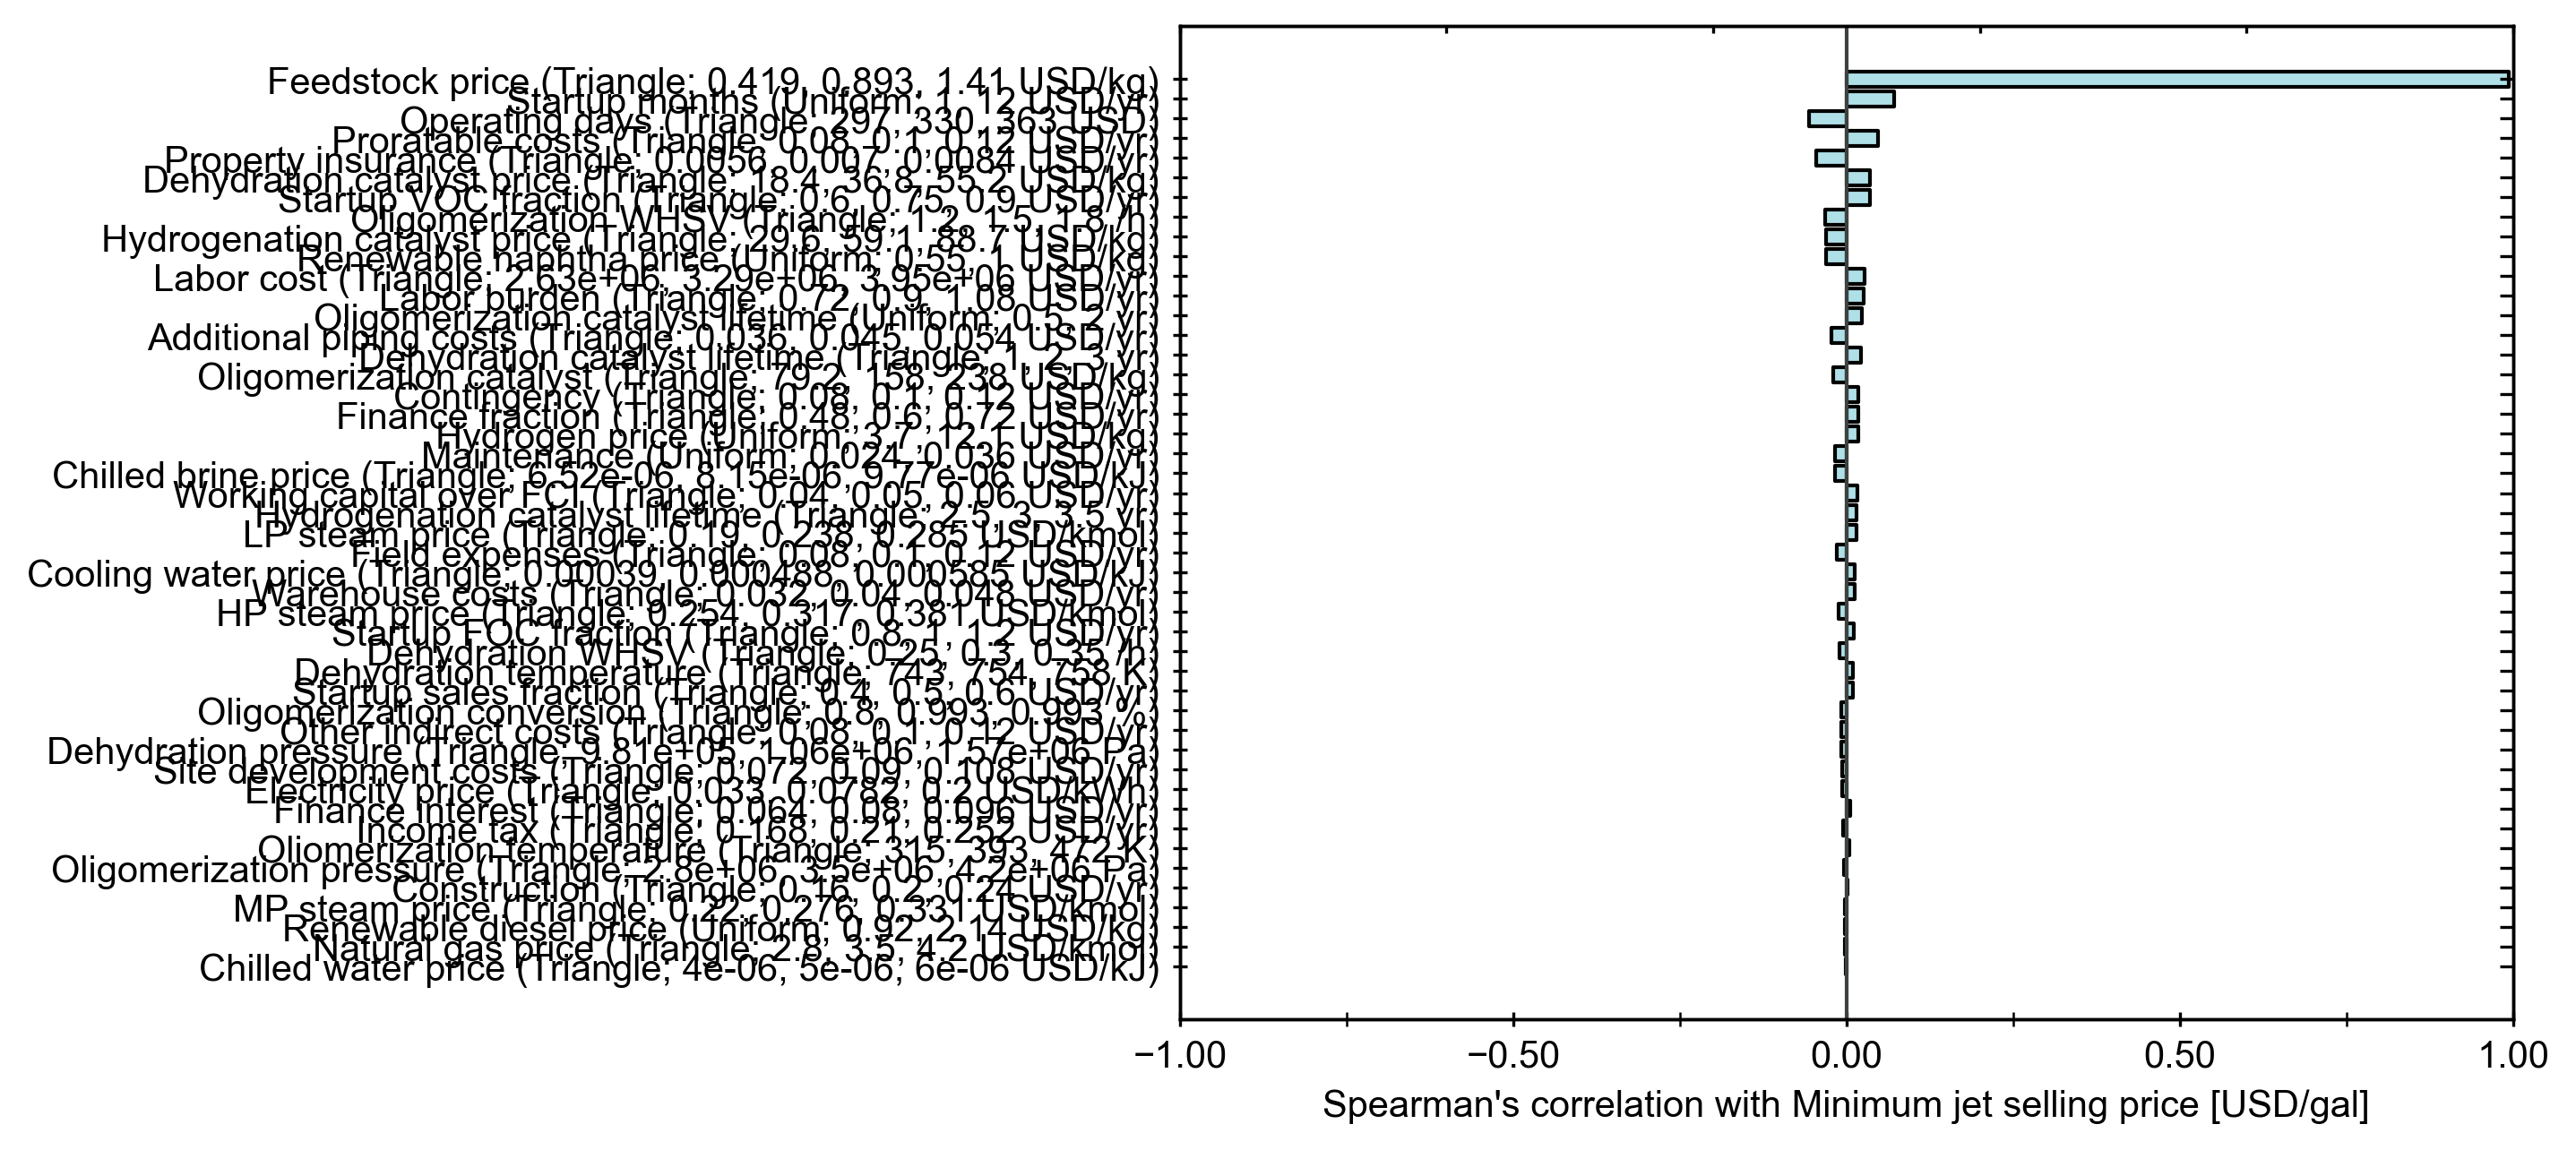

In [58]:
sensitivity = bst.plots.plot_spearman_1d(df_rho["ATJ-TEA", "Minimum jet selling price [USD/gal]"],
                           index=[i.describe() for i in model.parameters],
                           name="Minimum jet selling price [USD/gal]")

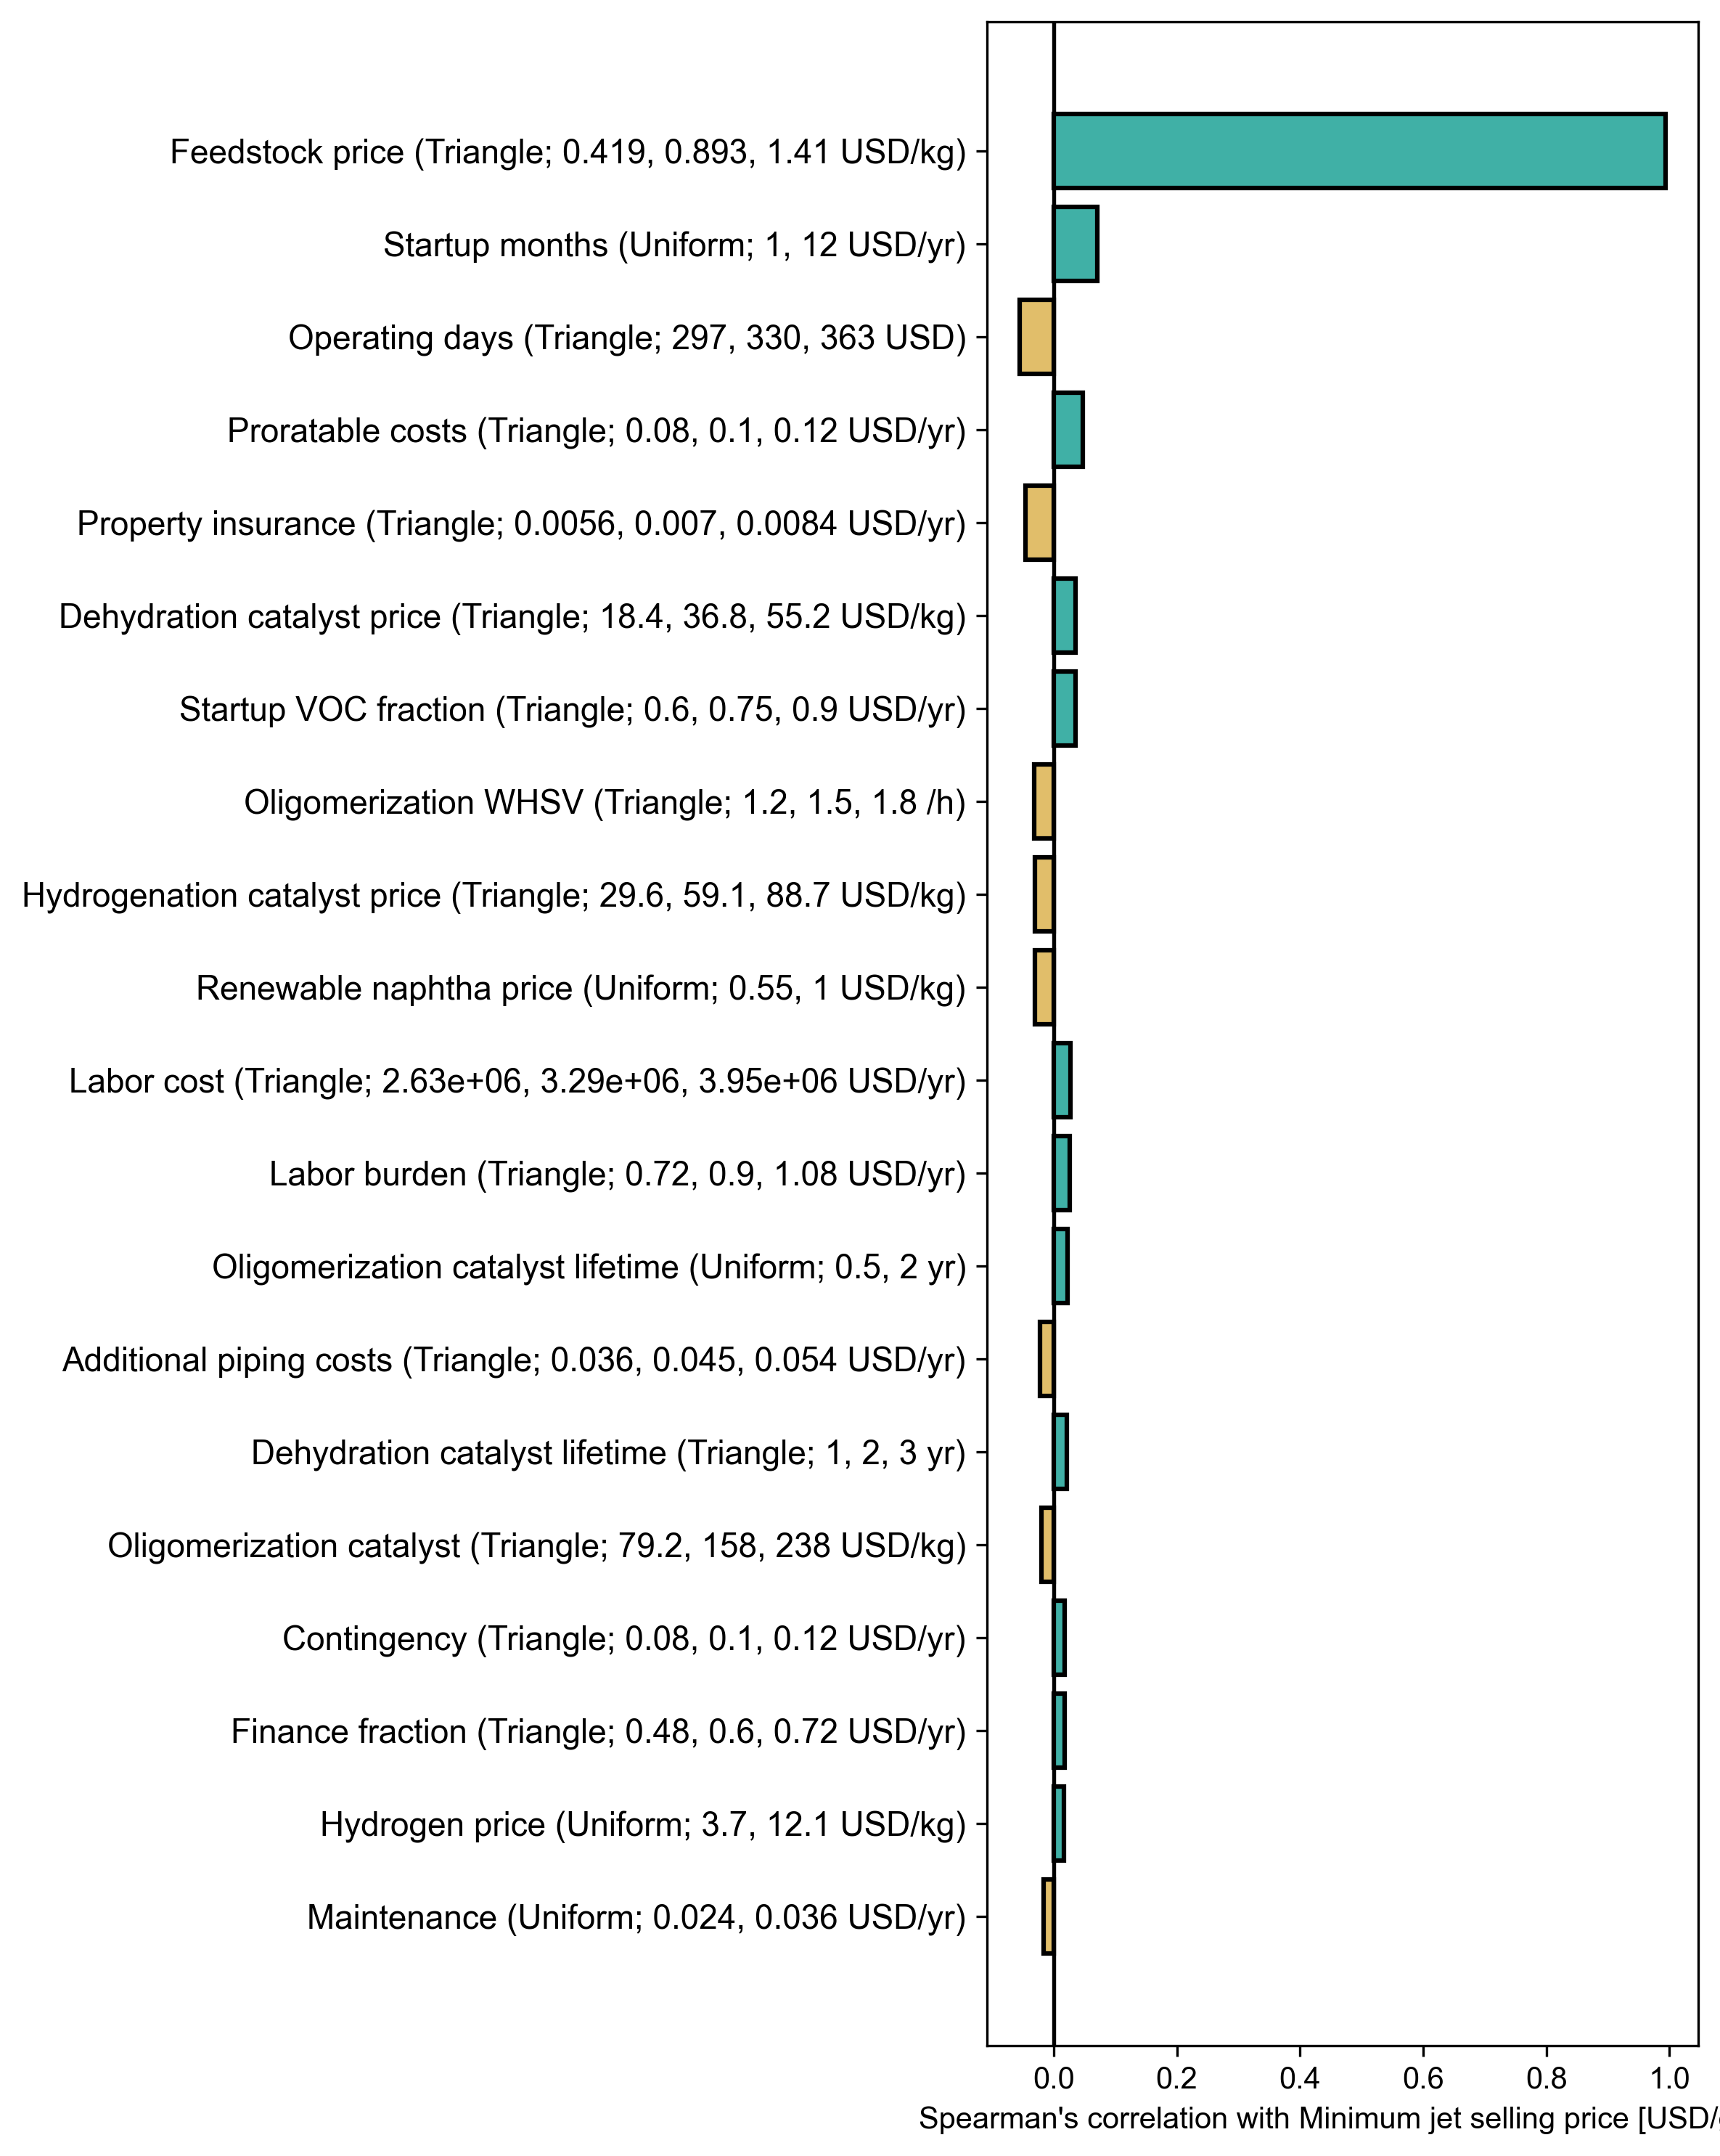

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Assume rho, labels, and model.parameters as before
N =  20 # Number of top parameters to plot
rho = df_rho["ATJ-TEA", "Minimum jet selling price [USD/gal]"]
labels = [i.describe() for i in model.parameters]
values = rho.values

sorted_idx = np.argsort(np.abs(values))[::-1]
top_idx = sorted_idx[:N]
values_top = values[top_idx]
labels_top = np.array(labels)[top_idx]
colors = ['#40B0A6' if v > 0 else '#E1BE6A' for v in values_top]

fig, ax = plt.subplots(figsize=(8, max(5, N * 0.5)))
y_pos = np.arange(N)

# Add edgecolor and linewidth to the barh call
ax.barh(
    y_pos,
    values_top,
    color=colors,
    edgecolor='black',     # Border color
    linewidth=1.5          # Border thickness
)


ax.axvline(x=0, color='k', linewidth=1.3, zorder=0)

ax.set_yticks(y_pos)
ax.set_yticklabels(labels_top, fontsize=11)
ax.invert_yaxis()

ax.set_xlabel("Spearman's correlation with Minimum jet selling price [USD/gal]")
#ax.set_title(f"Top {N} Sensitivity Parameters (Spearman's rho)")
'''
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#B22222', edgecolor='black', label='Increase raises MJSP'),
    Patch(facecolor='#4682B4', edgecolor='black', label='Increase lowers MJSP'),
]
ax.legend(handles=legend_elements, loc='lower right')
'''
plt.savefig('sensitivity_3.png', dpi = 300, bbox_inches = 'tight')
plt.tight_layout()
plt.show()
